# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

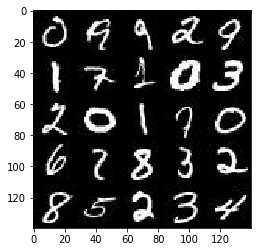

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

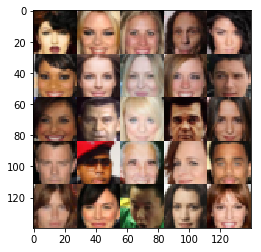

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    shape = (None, image_width, image_height, image_channels)
    real_inputs = tf.placeholder(tf.float32, shape = shape, name='real_inputs')
    z_data      = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, shape=(None),  name='learning_rate')
    return real_inputs, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)

        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generate_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generate_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generate_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    return discriminator_loss, generate_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    batch, image_width, image_height, image_channels = data_shape
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    batch_count = 0
    n_images = 16
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                dis = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                gen = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                batch_count += 1
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 3.1937
Epoch 1/2... Discriminator Loss: 0.1256... Generator Loss: 3.7074
Epoch 1/2... Discriminator Loss: 0.2568... Generator Loss: 11.6718
Epoch 1/2... Discriminator Loss: 0.2510... Generator Loss: 4.3719
Epoch 1/2... Discriminator Loss: 0.1442... Generator Loss: 4.0766
Epoch 1/2... Discriminator Loss: 0.2228... Generator Loss: 3.4548
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.6711
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 3.2449


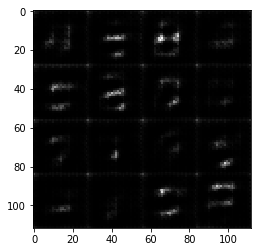

Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 2.5043
Epoch 1/2... Discriminator Loss: 1.8051... Generator Loss: 6.3267
Epoch 1/2... Discriminator Loss: 2.7593... Generator Loss: 5.5739
Epoch 1/2... Discriminator Loss: 0.6110... Generator Loss: 3.0162
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 3.9839
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 2.1506
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 2.3250
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.3445
Epoch 1/2... Discriminator Loss: 2.2522... Generator Loss: 0.2115


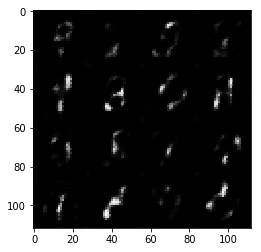

Epoch 1/2... Discriminator Loss: 2.0135... Generator Loss: 3.8776
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 2.2200
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 1.9501
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.8770... Generator Loss: 4.2896
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 3.1772
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.6041


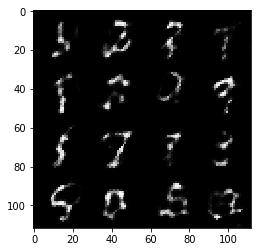

Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.1520
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 1.6066
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 2.1687
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.4853
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 0.8645
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.0494
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.8508


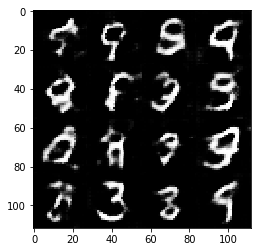

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.6461... Generator Loss: 0.4102
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 2.4564... Generator Loss: 3.8152
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.8259
Epoch 2/2... Discriminator Loss: 1.1090... Generator Loss: 1.4080


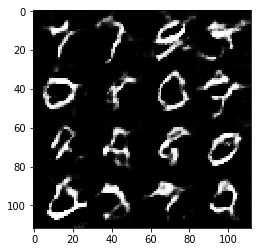

Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 1.0454
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.5935
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.6605


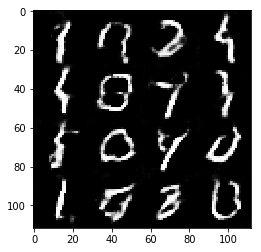

Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.4960
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.5822
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 2.7297
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 2.9788
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 2.0131
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.6684


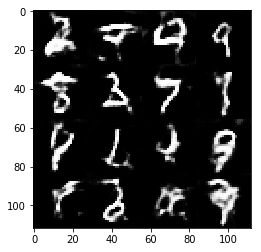

Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 2.9108
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.5026
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.9293
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.5981
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.8513
Epoch 2/2... Discriminator Loss: 4.1373... Generator Loss: 0.0501
Epoch 2/2... Discriminator Loss: 1.8571... Generator Loss: 0.9244
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 1.0156


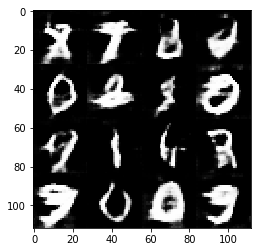

Epoch 2/2... Discriminator Loss: 1.5156... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 1.3348
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 3.8727... Generator Loss: 5.3979


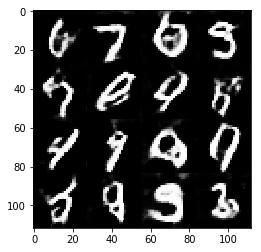

Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 2.1926


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.0004... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 0.1714... Generator Loss: 5.8026
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 3.8533
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 4.3896
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 3.1475... Generator Loss: 0.0950
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 3.0167


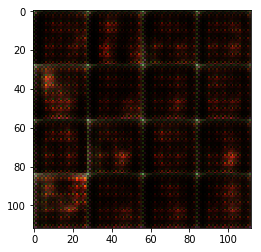

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.9192
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 2.9183
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.6676... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.6184


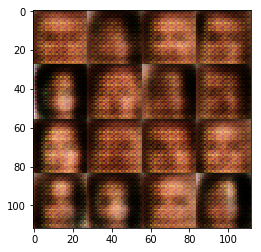

Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 3.4834
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.2238
Epoch 1/1... Discriminator Loss: 2.5237... Generator Loss: 4.7235
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.4537


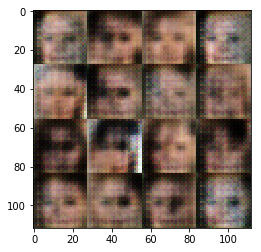

Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 3.2102
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.7407
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.9247


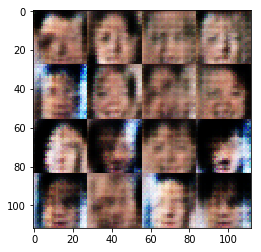

Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.9064... Generator Loss: 0.2752
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 1.0462


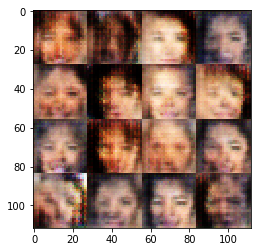

Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 2.3080
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.1934


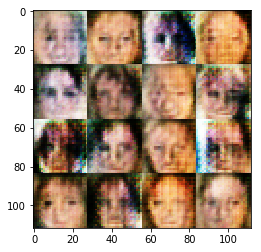

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.9280
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.8838
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 2.5486
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 2.1604
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.7815
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.7005


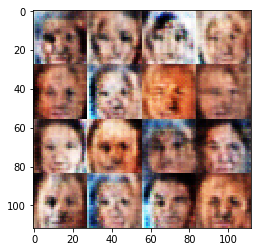

Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 2.2112
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.8333


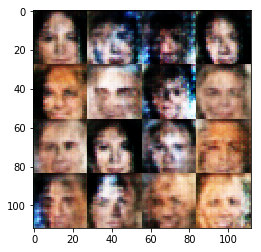

Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.9391


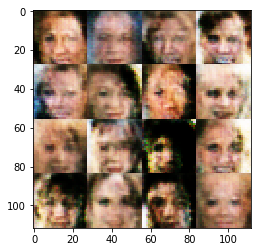

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 2.1590
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 2.0002


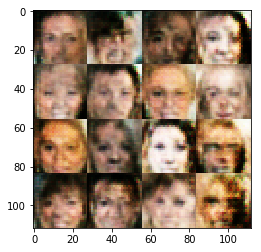

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 2.0196
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 1.0943


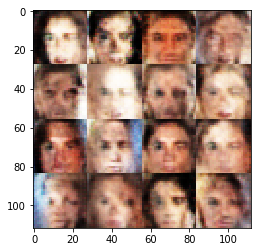

Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 2.2517
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 1.7795... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.5653


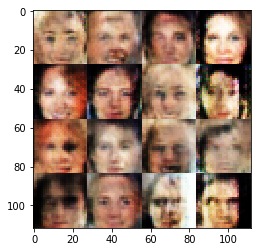

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 2.4695... Generator Loss: 3.6709
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6459


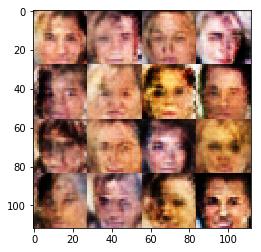

Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 2.1072
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 2.0119... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.3120
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.9375


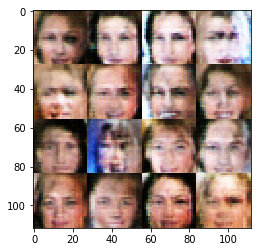

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.6570
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.6820
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.5893
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.7544


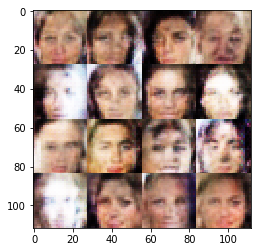

Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.5899


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.